In [2]:
import pandas as pd
import numpy as np

def merge_csv_files(file1_path, file2_path, output_path, merge_strategy='left'):
    """
    Merge two CSV files based on common columns.

    Parameters:
    file1_path (str): Path to the first CSV file (with player data)
    file2_path (str): Path to the second CSV file (with team metadata)
    output_path (str): Path for the merged output CSV file
    merge_strategy (str): 'left', 'right', 'inner', or 'outer'
    """

    try:
        # Read the CSV files
        print("Reading CSV files...")
        df1 = pd.read_csv(file1_path)
        df2 = pd.read_csv(file2_path)

        print(f"File 1 shape: {df1.shape}")
        print(f"File 2 shape: {df2.shape}")

        # Display first few rows to understand the data
        print("\nFirst few rows of File 1:")
        print(df1.head())
        print("\nFirst few rows of File 2:")
        print(df2.head())

        # Clean column names (remove extra spaces)
        df1.columns = df1.columns.str.strip()
        df2.columns = df2.columns.str.strip()

        # Identify potential merge keys
        common_cols = set(df1.columns) & set(df2.columns)
        print(f"\nCommon columns: {common_cols}")

        # Strategy 1: Merge on College_Name and Team/Team_Name
        if 'College_Name' in common_cols:
            # Check if we can also match on team names
            team_col_df1 = 'Team' if 'Team' in df1.columns else None
            team_col_df2 = 'Team_Name' if 'Team_Name' in df2.columns else None

            if team_col_df1 and team_col_df2:
                print(f"\nMerging on College_Name and Team columns...")
                # Rename Team_Name to Team for consistency
                df2_renamed = df2.rename(columns={'Team_Name': 'Team'})
                merged_df = pd.merge(df1, df2_renamed,
                                   on=['College_Name', 'Team'],
                                   how=merge_strategy,
                                   suffixes=('_file1', '_file2'))
            else:
                print(f"\nMerging on College_Name only...")
                merged_df = pd.merge(df1, df2,
                                   on='College_Name',
                                   how=merge_strategy,
                                   suffixes=('_file1', '_file2'))
        else:
            print("\nNo common merge key found. Concatenating files...")
            # If no common key, we'll concatenate and fill missing values
            # First, align columns
            all_cols = list(set(df1.columns) | set(df2.columns))

            # Add missing columns to each dataframe
            for col in all_cols:
                if col not in df1.columns:
                    df1[col] = np.nan
                if col not in df2.columns:
                    df2[col] = np.nan

            # Reorder columns to match
            df1 = df1[all_cols]
            df2 = df2[all_cols]

            # Concatenate
            merged_df = pd.concat([df1, df2], ignore_index=True)

        print(f"\nMerged dataframe shape: {merged_df.shape}")
        print(f"Columns in merged file: {list(merged_df.columns)}")

        # Save the merged file
        merged_df.to_csv(output_path, index=False)
        print(f"\nMerged file saved to: {output_path}")

        # Display summary statistics
        print(f"\nSummary:")
        print(f"Total rows in merged file: {len(merged_df)}")
        print(f"Total columns in merged file: {len(merged_df.columns)}")

        # Check for any data quality issues
        null_counts = merged_df.isnull().sum()
        if null_counts.sum() > 0:
            print(f"\nColumns with missing values:")
            print(null_counts[null_counts > 0])

        return merged_df

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return None

def advanced_merge_with_team_analysis(file1_path, file2_path, output_path):
    """
    Advanced merge function that analyzes team patterns and provides multiple merge options.
    """

    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)

    # Clean column names
    df1.columns = df1.columns.str.strip()
    df2.columns = df2.columns.str.strip()

    print("=== DATA ANALYSIS ===")
    print(f"File 1: {df1.shape[0]} rows, {df1.shape[1]} columns")
    print(f"File 2: {df2.shape[0]} rows, {df2.shape[1]} columns")

    # Analyze team distributions
    if 'Team' in df1.columns:
        print(f"\nUnique teams in File 1: {df1['Team'].nunique()}")
        print(f"Sample teams: {df1['Team'].unique()[:5]}")

    if 'Team_Name' in df2.columns:
        print(f"Unique teams in File 2: {df2['Team_Name'].nunique()}")
        print(f"Sample teams: {df2['Team_Name'].unique()[:5]}")

    # Check for team name matches
    if 'Team' in df1.columns and 'Team_Name' in df2.columns:
        teams_df1 = set(df1['Team'].dropna().unique())
        teams_df2 = set(df2['Team_Name'].dropna().unique())
        common_teams = teams_df1 & teams_df2
        print(f"\nTeams appearing in both files: {len(common_teams)}")
        if len(common_teams) > 0:
            print(f"Sample common teams: {list(common_teams)[:5]}")

    # Perform the merge
    df2_renamed = df2.rename(columns={'Team_Name': 'Team'})

    # Try different merge strategies
    results = {}

    # Inner join (only matching records)
    inner_merge = pd.merge(df1, df2_renamed, on=['College_Name', 'Team'], how='inner')
    results['inner'] = inner_merge

    # Left join (all records from file 1)
    left_merge = pd.merge(df1, df2_renamed, on=['College_Name', 'Team'], how='left')
    results['left'] = left_merge

    # Outer join (all records from both files)
    outer_merge = pd.merge(df1, df2_renamed, on=['College_Name', 'Team'], how='outer')
    results['outer'] = outer_merge

    print(f"\n=== MERGE RESULTS ===")
    for strategy, df in results.items():
        print(f"{strategy.upper()} join: {df.shape[0]} rows")

    # Save the left join by default (most common use case)
    left_merge.to_csv(output_path, index=False)

    return results

In [3]:
# Example usage
if __name__ == "__main__":
    # Basic merge
    file1_path = "file1.csv"  # Replace with your first CSV file path
    file2_path = "file2.csv"  # Replace with your second CSV file path
    output_path = "merged_file.csv"

    # Option 1: Simple merge
    merged_data = merge_csv_files(file1_path, file2_path, output_path, merge_strategy='left')

    # Option 2: Advanced analysis and merge
    # results = advanced_merge_with_team_analysis(file1_path, file2_path, output_path)

    print("\nMerge completed successfully!")

Reading CSV files...
File 1 shape: (3504, 10)
File 2 shape: (2968, 22)

First few rows of File 1:
                             UUID       Team_Name  Team_Size        City  \
0        1_SheCodes_Coimbatore_KI        SheCodes          3  Coimbatore   
1         2_Cyber01_Coimbatore_KI         Cyber01          4  Coimbatore   
2     3_Techtroupes_Coimbatore_KI    Tech troupes          5  Coimbatore   
3   4_TECHINOVATORS_Coimbatore_KI  TECH INOVATORS          5  Coimbatore   
4  5_PanchCoders_Coimbatore_SKCET     PanchCoders          5  Coimbatore   

                                        College_Name        Degree  \
0                             Karpagam Instituitions  B.tech / B.E   
1                             Karpagam Instituitions  B.tech / B.E   
2                             Karpagam Instituitions  B.tech / B.E   
3                             Karpagam Instituitions  B.tech / B.E   
4  Sri Krishna College of Engineering and Technology  B.tech / B.E   

                        

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

class HackathonAnalyzer:
    def __init__(self, csv_file_path):
        """Initialize the analyzer with the CSV file path"""
        self.csv_file_path = csv_file_path
        self.df = None
        self.question_mapping = {
            'Q1': 'Theme Relevance',
            'Q2': 'Problem Solving Impact',
            'Q3': 'Originality',
            'Q4': 'Market Disruption Potential',
            'Q5': 'Implementation Feasibility',
            'Q6': 'Prototype Development',
            'Q7': 'Problem Significance',
            'Q8': 'Long-term Impact'
        }

    def load_and_clean_data(self):
        """Load the CSV file and perform initial data cleaning"""
        print("Loading and cleaning data...")
        try:
            self.df = pd.read_csv(self.csv_file_path)
            print(f"Data loaded successfully. Shape: {self.df.shape}")

            # Display basic info
            print("\nColumn names:")
            print(self.df.columns.tolist())

            # Check for missing values
            print("\nMissing values before cleaning:")
            missing_values = self.df.isnull().sum()
            print(missing_values[missing_values > 0])

            # Clean and convert question columns to numeric
            question_columns = []
            for participant in ['P1', 'P2']:
                for q_num in range(1, 9):
                    col_name = f'{participant}_Q{q_num}'
                    if col_name in self.df.columns:
                        question_columns.append(col_name)

            print(f"\nCleaning question columns: {question_columns}")

            # Convert question columns to numeric, handling errors
            for col in question_columns:
                print(f"Processing {col}...")
                # First, let's see what values are in this column
                unique_vals = self.df[col].unique()
                print(f"  Unique values in {col}: {unique_vals}")

                # Convert to numeric, coerce errors to NaN
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce')

                # Fill NaN values with 0 (assuming missing ratings = 0)
                nan_count = self.df[col].isnull().sum()
                if nan_count > 0:
                    print(f"  Found {nan_count} non-numeric values in {col}, replacing with 0")
                    self.df[col] = self.df[col].fillna(0)

                # Ensure values are within valid range (0-2)
                invalid_range = ((self.df[col] < 0) | (self.df[col] > 2)).sum()
                if invalid_range > 0:
                    print(f"  Found {invalid_range} values outside 0-2 range in {col}, clipping to range")
                    self.df[col] = self.df[col].clip(0, 2)

            # Clean Team_Size if it exists
            if 'Team_Size' in self.df.columns:
                self.df['Team_Size'] = pd.to_numeric(self.df['Team_Size'], errors='coerce')
                self.df['Team_Size'] = self.df['Team_Size'].fillna(2)  # Default team size = 2

            # Clean string columns by removing extra whitespace
            string_columns = ['Team_Name', 'City', 'College_Name', 'Department', 'Theme',
                            'Ideal_Title', 'P1_Name', 'P2_Name', 'P1_Role', 'P2_Role']

            for col in string_columns:
                if col in self.df.columns:
                    self.df[col] = self.df[col].astype(str).str.strip()
                    # Replace empty strings with 'Unknown'
                    self.df[col] = self.df[col].replace(['', 'nan', 'None'], 'Unknown')

            print("\nData cleaning completed!")
            print("Final missing values:")
            missing_values_final = self.df.isnull().sum()
            print(missing_values_final[missing_values_final > 0])

            # Verify question columns are now numeric
            print("\nQuestion column data types after cleaning:")
            for col in question_columns:
                if col in self.df.columns:
                    print(f"  {col}: {self.df[col].dtype}, range: {self.df[col].min():.1f}-{self.df[col].max():.1f}")

            return True

        except FileNotFoundError:
            print(f"Error: File '{self.csv_file_path}' not found.")
            return False
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            print("Full error details:")
            import traceback
            traceback.print_exc()
            return False

    def calculate_scores(self):
        """Calculate individual and team scores"""
        print("\nCalculating scores...")

        # Define question columns for P1 and P2 (only include columns that exist)
        p1_questions = [f'P1_Q{i}' for i in range(1, 9) if f'P1_Q{i}' in self.df.columns]
        p2_questions = [f'P2_Q{i}' for i in range(1, 9) if f'P2_Q{i}' in self.df.columns]

        print(f"P1 question columns found: {p1_questions}")
        print(f"P2 question columns found: {p2_questions}")

        # Verify all columns are numeric
        for col in p1_questions + p2_questions:
            if not pd.api.types.is_numeric_dtype(self.df[col]):
                print(f"Warning: {col} is not numeric type: {self.df[col].dtype}")
                # Try to convert again
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce').fillna(0)

        # Calculate individual scores only if columns exist
        if p1_questions:
            self.df['P1_Total_Score'] = self.df[p1_questions].sum(axis=1)
            print(f"P1 total score range: {self.df['P1_Total_Score'].min():.1f} - {self.df['P1_Total_Score'].max():.1f}")
        else:
            print("No P1 question columns found!")
            self.df['P1_Total_Score'] = 0

        if p2_questions:
            self.df['P2_Total_Score'] = self.df[p2_questions].sum(axis=1)
            print(f"P2 total score range: {self.df['P2_Total_Score'].min():.1f} - {self.df['P2_Total_Score'].max():.1f}")
        else:
            print("No P2 question columns found!")
            self.df['P2_Total_Score'] = 0

        # Calculate team average score
        self.df['Team_Average_Score'] = (self.df['P1_Total_Score'] + self.df['P2_Total_Score']) / 2

        # Calculate question-wise team averages
        for i in range(1, 9):
            p1_col = f'P1_Q{i}'
            p2_col = f'P2_Q{i}'

            if p1_col in self.df.columns and p2_col in self.df.columns:
                self.df[f'Team_Q{i}_Avg'] = (self.df[p1_col] + self.df[p2_col]) / 2
            elif p1_col in self.df.columns:
                self.df[f'Team_Q{i}_Avg'] = self.df[p1_col]  # Use only P1 if P2 missing
                print(f"Warning: Using only P1 score for Q{i}")
            elif p2_col in self.df.columns:
                self.df[f'Team_Q{i}_Avg'] = self.df[p2_col]  # Use only P2 if P1 missing
                print(f"Warning: Using only P2 score for Q{i}")
            else:
                self.df[f'Team_Q{i}_Avg'] = 0  # Default to 0 if both missing
                print(f"Warning: Both P1 and P2 missing for Q{i}, using 0")

        print(f"Team average score range: {self.df['Team_Average_Score'].min():.1f} - {self.df['Team_Average_Score'].max():.1f}")
        print("Scores calculated successfully!")

    def basic_statistics(self):
        """Generate basic statistical summary"""
        print("\n" + "="*50)
        print("BASIC STATISTICS")
        print("="*50)

        # Overall statistics
        print(f"Total number of teams: {len(self.df)}")
        print(f"Total number of participants: {len(self.df) * 2}")  # Assuming 2 people per team

        # Team size distribution
        if 'Team_Size' in self.df.columns:
            print(f"\nTeam size distribution:")
            print(self.df['Team_Size'].value_counts().sort_index())

        # City distribution
        if 'City' in self.df.columns:
            print(f"\nTop 10 cities by participation:")
            print(self.df['City'].value_counts().head(10))

        # College distribution
        if 'College_Name' in self.df.columns:
            print(f"\nTop 10 colleges by participation:")
            print(self.df['College_Name'].value_counts().head(10))

        # Theme distribution
        if 'Theme' in self.df.columns:
            print(f"\nTheme distribution:")
            print(self.df['Theme'].value_counts())

        # Department distribution
        if 'Department' in self.df.columns:
            print(f"\nTop 10 departments:")
            print(self.df['Department'].value_counts().head(10))

    def score_analysis(self):
        """Analyze scoring patterns"""
        print("\n" + "="*50)
        print("SCORE ANALYSIS")
        print("="*50)

        # Overall score statistics
        print("Team Average Score Statistics:")
        print(f"Mean: {self.df['Team_Average_Score'].mean():.2f}")
        print(f"Median: {self.df['Team_Average_Score'].median():.2f}")
        print(f"Std Dev: {self.df['Team_Average_Score'].std():.2f}")
        print(f"Min: {self.df['Team_Average_Score'].min():.2f}")
        print(f"Max: {self.df['Team_Average_Score'].max():.2f}")

        # Question-wise analysis
        print(f"\nQuestion-wise Team Average Scores:")
        for i in range(1, 9):
            col = f'Team_Q{i}_Avg'
            question_name = self.question_mapping[f'Q{i}']
            mean_score = self.df[col].mean()
            print(f"Q{i} ({question_name}): {mean_score:.2f}")

        # Top performing teams
        print(f"\nTop 10 performing teams:")
        top_teams = self.df.nlargest(10, 'Team_Average_Score')[['Team_Name', 'Team_Average_Score', 'City', 'College_Name']]
        print(top_teams.to_string(index=False))

    def inter_rater_reliability(self):
        """Analyze agreement between P1 and P2 ratings"""
        print("\n" + "="*50)
        print("INTER-RATER RELIABILITY ANALYSIS")
        print("="*50)

        correlations = []
        valid_questions = []

        for i in range(1, 9):
            p1_col = f'P1_Q{i}'
            p2_col = f'P2_Q{i}'

            # Only calculate correlation if both columns exist and have data
            if p1_col in self.df.columns and p2_col in self.df.columns:
                # Check if there's any variation in the data
                if self.df[p1_col].std() > 0 and self.df[p2_col].std() > 0:
                    correlation = self.df[p1_col].corr(self.df[p2_col])
                    if not pd.isna(correlation):
                        correlations.append(correlation)
                        valid_questions.append(i)
                        question_name = self.question_mapping[f'Q{i}']
                        print(f"Q{i} ({question_name}): r = {correlation:.3f}")
                    else:
                        print(f"Q{i}: Unable to calculate correlation (insufficient data variation)")
                else:
                    print(f"Q{i}: No variation in scores, correlation not meaningful")
            else:
                print(f"Q{i}: Missing P1 or P2 data, skipping correlation")

        if correlations:
            print(f"\nOverall average correlation: {np.mean(correlations):.3f}")
            print(f"Based on {len(correlations)} valid question pairs")

            # Calculate overall correlation between P1 and P2 total scores
            if 'P1_Total_Score' in self.df.columns and 'P2_Total_Score' in self.df.columns:
                if self.df['P1_Total_Score'].std() > 0 and self.df['P2_Total_Score'].std() > 0:
                    overall_corr = self.df['P1_Total_Score'].corr(self.df['P2_Total_Score'])
                    if not pd.isna(overall_corr):
                        print(f"Overall total score correlation: {overall_corr:.3f}")
                    else:
                        print("Overall total score correlation: Unable to calculate")
        else:
            print("No valid correlations could be calculated")

    def theme_analysis(self):
        """Analyze performance by theme"""
        if 'Theme' not in self.df.columns:
            print("Theme column not found, skipping theme analysis")
            return

        print("\n" + "="*50)
        print("THEME-WISE ANALYSIS")
        print("="*50)

        theme_stats = self.df.groupby('Theme').agg({
            'Team_Average_Score': ['count', 'mean', 'std'],
            'Team_Q1_Avg': 'mean',  # Theme relevance
            'Team_Q2_Avg': 'mean',  # Problem solving
            'Team_Q3_Avg': 'mean',  # Originality
            'Team_Q4_Avg': 'mean'   # Market disruption
        }).round(2)

        print("Theme-wise statistics:")
        print(theme_stats)

    def college_analysis(self):
        """Analyze performance by college"""
        if 'College_Name' not in self.df.columns:
            print("College_Name column not found, skipping college analysis")
            return

        print("\n" + "="*50)
        print("COLLEGE PERFORMANCE ANALYSIS")
        print("="*50)

        # Only analyze colleges with more than 2 teams
        college_stats = self.df.groupby('College_Name').agg({
            'Team_Average_Score': ['count', 'mean', 'std'],
        }).round(2)

        college_stats = college_stats[college_stats[('Team_Average_Score', 'count')] > 2]
        college_stats = college_stats.sort_values(('Team_Average_Score', 'mean'), ascending=False)

        print("Top colleges by average performance (min 3 teams):")
        print(college_stats.head(10))

    def clustering_analysis(self):
        """Perform clustering analysis on teams"""
        print("\n" + "="*50)
        print("CLUSTERING ANALYSIS")
        print("="*50)

        # Prepare data for clustering
        cluster_cols = [f'Team_Q{i}_Avg' for i in range(1, 9)]
        cluster_data = self.df[cluster_cols].fillna(self.df[cluster_cols].mean())

        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(cluster_data)

        # Perform K-means clustering
        kmeans = KMeans(n_clusters=4, random_state=42)
        self.df['Cluster'] = kmeans.fit_predict(scaled_data)

        # Analyze clusters
        print("Cluster analysis (4 clusters):")
        cluster_analysis = self.df.groupby('Cluster').agg({
            'Team_Average_Score': ['count', 'mean'],
            **{f'Team_Q{i}_Avg': 'mean' for i in range(1, 9)}
        }).round(2)

        print(cluster_analysis)

        # Label clusters based on characteristics
        cluster_labels = {
            0: "Cluster 0",
            1: "Cluster 1",
            2: "Cluster 2",
            3: "Cluster 3"
        }

        for cluster_id in range(4):
            cluster_data = self.df[self.df['Cluster'] == cluster_id]
            avg_score = cluster_data['Team_Average_Score'].mean()
            team_count = len(cluster_data)

            print(f"\n{cluster_labels[cluster_id]}: {team_count} teams, Avg Score: {avg_score:.2f}")

    def generate_visualizations(self):
        """Generate comprehensive visualizations"""
        print("\n" + "="*50)
        print("GENERATING VISUALIZATIONS")
        print("="*50)

        # Set up the plotting style
        plt.style.use('default')
        sns.set_palette("husl")

        # Create a figure with multiple subplots
        fig = plt.figure(figsize=(20, 24))

        # 1. Score distribution
        plt.subplot(4, 3, 1)
        plt.hist(self.df['Team_Average_Score'], bins=20, alpha=0.7, edgecolor='black')
        plt.title('Distribution of Team Average Scores')
        plt.xlabel('Average Score')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        # 2. Question-wise average scores
        plt.subplot(4, 3, 2)
        question_avgs = [self.df[f'Team_Q{i}_Avg'].mean() for i in range(1, 9)]
        question_labels = [f'Q{i}' for i in range(1, 9)]
        bars = plt.bar(question_labels, question_avgs, alpha=0.7)
        plt.title('Average Scores by Question')
        plt.xlabel('Questions')
        plt.ylabel('Average Score')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, val in zip(bars, question_avgs):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.2f}', ha='center', va='bottom')

        # 3. Inter-rater correlation heatmap
        plt.subplot(4, 3, 3)
        corr_data = []
        for i in range(1, 9):
            corr_data.append(self.df[f'P1_Q{i}'].corr(self.df[f'P2_Q{i}']))

        corr_matrix = np.array(corr_data).reshape(1, -1)
        sns.heatmap(corr_matrix, annot=True, fmt='.3f',
                   xticklabels=[f'Q{i}' for i in range(1, 9)],
                   yticklabels=['P1 vs P2'], cmap='coolwarm', center=0)
        plt.title('Inter-rater Correlations')

        # 4. Theme distribution (if available)
        if 'Theme' in self.df.columns:
            plt.subplot(4, 3, 4)
            theme_counts = self.df['Theme'].value_counts()
            plt.pie(theme_counts.values, labels=theme_counts.index, autopct='%1.1f%%')
            plt.title('Theme Distribution')

        # 5. City distribution (top 10)
        if 'City' in self.df.columns:
            plt.subplot(4, 3, 5)
            top_cities = self.df['City'].value_counts().head(10)
            plt.barh(range(len(top_cities)), top_cities.values)
            plt.yticks(range(len(top_cities)), top_cities.index)
            plt.title('Top 10 Cities by Participation')
            plt.xlabel('Number of Teams')

        # 6. Score vs Theme (if available)
        if 'Theme' in self.df.columns:
            plt.subplot(4, 3, 6)
            sns.boxplot(data=self.df, x='Theme', y='Team_Average_Score')
            plt.title('Score Distribution by Theme')
            plt.xticks(rotation=45)

        # 7. P1 vs P2 total scores scatter plot
        plt.subplot(4, 3, 7)
        plt.scatter(self.df['P1_Total_Score'], self.df['P2_Total_Score'], alpha=0.6)
        plt.xlabel('P1 Total Score')
        plt.ylabel('P2 Total Score')
        plt.title('P1 vs P2 Total Scores')
        plt.plot([0, 16], [0, 16], 'r--', alpha=0.5)  # Perfect agreement line
        plt.grid(True, alpha=0.3)

        # 8. Question difficulty (based on average scores)
        plt.subplot(4, 3, 8)
        question_difficulty = [(2 - self.df[f'Team_Q{i}_Avg'].mean()) for i in range(1, 9)]
        question_names = [self.question_mapping[f'Q{i}'][:15] + '...' if len(self.question_mapping[f'Q{i}']) > 15
                         else self.question_mapping[f'Q{i}'] for i in range(1, 9)]

        bars = plt.bar(range(8), question_difficulty, alpha=0.7)
        plt.xlabel('Questions')
        plt.ylabel('Difficulty (2 - avg score)')
        plt.title('Question Difficulty Analysis')
        plt.xticks(range(8), [f'Q{i+1}' for i in range(8)], rotation=45)
        plt.grid(True, alpha=0.3)

        # 9. Team size distribution (if available)
        if 'Team_Size' in self.df.columns:
            plt.subplot(4, 3, 9)
            team_size_counts = self.df['Team_Size'].value_counts().sort_index()
            plt.bar(team_size_counts.index, team_size_counts.values, alpha=0.7)
            plt.title('Team Size Distribution')
            plt.xlabel('Team Size')
            plt.ylabel('Number of Teams')
            plt.grid(True, alpha=0.3)

        # 10. Clustering visualization (PCA)
        if 'Cluster' in self.df.columns:
            plt.subplot(4, 3, 10)
            cluster_cols = [f'Team_Q{i}_Avg' for i in range(1, 9)]
            cluster_data = self.df[cluster_cols].fillna(self.df[cluster_cols].mean())

            pca = PCA(n_components=2)
            pca_data = pca.fit_transform(StandardScaler().fit_transform(cluster_data))

            scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1],
                                c=self.df['Cluster'], cmap='viridis', alpha=0.6)
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            plt.title('Team Clusters (PCA Visualization)')
            plt.colorbar(scatter)

        # 11. Score correlation matrix
        plt.subplot(4, 3, 11)
        score_cols = [f'Team_Q{i}_Avg' for i in range(1, 9)]
        corr_matrix = self.df[score_cols].corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
        plt.title('Question Score Correlations')

        # 12. Top vs Bottom performers comparison
        plt.subplot(4, 3, 12)
        top_10_percent = int(len(self.df) * 0.1)
        bottom_10_percent = int(len(self.df) * 0.1)

        top_performers = self.df.nlargest(max(1, top_10_percent), 'Team_Average_Score')
        bottom_performers = self.df.nsmallest(max(1, bottom_10_percent), 'Team_Average_Score')

        top_avgs = [top_performers[f'Team_Q{i}_Avg'].mean() for i in range(1, 9)]
        bottom_avgs = [bottom_performers[f'Team_Q{i}_Avg'].mean() for i in range(1, 9)]

        x = np.arange(8)
        width = 0.35

        plt.bar(x - width/2, top_avgs, width, label='Top 10%', alpha=0.8)
        plt.bar(x + width/2, bottom_avgs, width, label='Bottom 10%', alpha=0.8)

        plt.xlabel('Questions')
        plt.ylabel('Average Score')
        plt.title('Top vs Bottom Performers')
        plt.xticks(x, [f'Q{i+1}' for i in range(8)])
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('hackathon_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("Comprehensive visualization saved as 'hackathon_analysis_comprehensive.png'")

    def generate_insights(self):
        """Generate key insights and recommendations"""
        print("\n" + "="*60)
        print("KEY INSIGHTS AND RECOMMENDATIONS")
        print("="*60)

        # Performance insights
        mean_score = self.df['Team_Average_Score'].mean()
        std_score = self.df['Team_Average_Score'].std()

        print("📊 PERFORMANCE INSIGHTS:")
        print(f"   • Average team performance: {mean_score:.2f}/2.0 ({mean_score/2*100:.1f}%)")
        print(f"   • Performance variation: σ = {std_score:.2f}")

        # Identify strongest and weakest areas
        question_avgs = [(i, self.df[f'Team_Q{i}_Avg'].mean()) for i in range(1, 9)]
        question_avgs.sort(key=lambda x: x[1], reverse=True)

        strongest_q = question_avgs[0]
        weakest_q = question_avgs[-1]

        print(f"   • Strongest area: Q{strongest_q[0]} ({self.question_mapping[f'Q{strongest_q[0]}']}) - {strongest_q[1]:.2f}")
        print(f"   • Weakest area: Q{weakest_q[0]} ({self.question_mapping[f'Q{weakest_q[0]}']}) - {weakest_q[1]:.2f}")

        # Inter-rater reliability insight
        correlations = [self.df[f'P1_Q{i}'].corr(self.df[f'P2_Q{i}']) for i in range(1, 9)]
        avg_correlation = np.mean(correlations)

        print(f"\n🤝 EVALUATION CONSISTENCY:")
        print(f"   • Average inter-rater correlation: {avg_correlation:.3f}")
        if avg_correlation > 0.7:
            print("   • Excellent agreement between evaluators")
        elif avg_correlation > 0.5:
            print("   • Good agreement between evaluators")
        else:
            print("   • Consider evaluator training for better consistency")

        # Theme insights (if available)
        if 'Theme' in self.df.columns:
            theme_performance = self.df.groupby('Theme')['Team_Average_Score'].mean().sort_values(ascending=False)
            print(f"\n🎯 THEME INSIGHTS:")
            print(f"   • Best performing theme: {theme_performance.index[0]} ({theme_performance.iloc[0]:.2f})")
            print(f"   • Most challenging theme: {theme_performance.index[-1]} ({theme_performance.iloc[-1]:.2f})")

        # Participation insights
        if 'City' in self.df.columns:
            city_participation = self.df['City'].value_counts()
            print(f"\n🌍 PARTICIPATION INSIGHTS:")
            print(f"   • Total cities represented: {len(city_participation)}")
            print(f"   • Highest participation: {city_participation.index[0]} ({city_participation.iloc[0]} teams)")

        if 'College_Name' in self.df.columns:
            college_participation = self.df['College_Name'].value_counts()
            print(f"   • Total colleges represented: {len(college_participation)}")
            print(f"   • Most active college: {college_participation.index[0]} ({college_participation.iloc[0]} teams)")

        # Recommendations
        print(f"\n💡 RECOMMENDATIONS:")
        print("   1. Focus on improving teams' performance in:", self.question_mapping[f'Q{weakest_q[0]}'])
        print("   2. Use high-performing teams as mentors for improvement areas")

        if avg_correlation < 0.6:
            print("   3. Provide additional training for evaluators to improve consistency")

        print("   4. Consider theme-specific workshops for challenging themes")
        print("   5. Encourage cross-city collaboration to share best practices")

    def export_results(self, filename='hackathon_analysis_results.csv'):
        """Export analyzed data with additional metrics"""
        print(f"\n📁 Exporting results to '{filename}'...")

        # Create export dataframe with original data plus calculated metrics
        export_df = self.df.copy()

        # Add percentile rankings
        export_df['Score_Percentile'] = export_df['Team_Average_Score'].rank(pct=True) * 100

        # Add performance categories
        export_df['Performance_Category'] = pd.cut(
            export_df['Team_Average_Score'],
            bins=[0, 0.8, 1.2, 1.6, 2.0],
            labels=['Needs Improvement', 'Fair', 'Good', 'Excellent']
        )

        export_df.to_csv(filename, index=False)
        print(f"Results exported successfully to '{filename}'")

    def run_complete_analysis(self):
        """Run the complete analysis pipeline"""
        print("🚀 Starting Complete Hackathon Analysis")
        print("="*60)

        # Load and clean data
        if not self.load_and_clean_data():
            return False

        # Calculate scores
        self.calculate_scores()

        # Run all analyses
        self.basic_statistics()
        self.score_analysis()
        self.inter_rater_reliability()
        self.theme_analysis()
        self.college_analysis()
        self.clustering_analysis()

        # Generate visualizations
        self.generate_visualizations()

        # Generate insights
        self.generate_insights()

        # Export results
        self.export_results()

        print("\n✅ Analysis completed successfully!")
        print("📊 Check the generated visualization: 'hackathon_analysis_comprehensive.png'")
        print("📁 Check the exported data: 'hackathon_analysis_results.csv'")

        return True



🔍 DEBUGGING MODE - Inspecting your data first...
Loading and cleaning data...
Error: File 'your_hackathon_data.csv' not found.


In [7]:
# Example usage
if __name__ == "__main__":
    # Initialize analyzer with your CSV file path
    analyzer = HackathonAnalyzer('merged_file.csv')  # Replace with your actual file path

    # First, let's just load and inspect the data
    print("🔍 DEBUGGING MODE - Inspecting your data first...")

    if analyzer.load_and_clean_data():
        print("\n" + "="*50)
        print("DATA INSPECTION COMPLETE")
        print("="*50)

        # Show first few rows
        print("\nFirst 3 rows of question columns:")
        question_cols = [col for col in analyzer.df.columns if 'P1_Q' in col or 'P2_Q' in col]
        if question_cols:
            print(analyzer.df[question_cols].head(3))
        else:
            print("No question columns found!")
            print("Available columns:", analyzer.df.columns.tolist())

        # Show data types
        print(f"\nQuestion column data types:")
        for col in question_cols[:8]:  # Show first 8
            if col in analyzer.df.columns:
                print(f"{col}: {analyzer.df[col].dtype}")

        print(f"\nReady to run full analysis? The data looks clean now!")
        print("To run full analysis, call: analyzer.run_complete_analysis()")

    # Uncomment the line below to run the full analysis
    # analyzer.run_complete_analysis()

    # Optional: Access specific analyses
    # analyzer.basic_statistics()
    # analyzer.score_analysis()
    # analyzer.generate_visualizations()

🔍 DEBUGGING MODE - Inspecting your data first...
Loading and cleaning data...
Data loaded successfully. Shape: (75418, 31)

Column names:
['UUID', 'Team_Name', 'Team_Size', 'City', 'College_Name', 'Degree', 'Department', 'Theme', 'Ideal_Title', 'Idea_Description', 'Team', 'P1_Name', 'P2_Name', 'P1_Role', 'P2_Role', 'P1_Q1', 'P1_Q2', 'P1_Q3', 'P1_Q4', 'P1_Q5', 'P1_Q6', 'P1_Q7', 'P1_Q8', 'P2_Q1', 'P2_Q2', 'P2_Q3', 'P2_Q4', 'P2_Q5', 'P2_Q6', 'P2_Q7', 'P2_Q8']

Missing values before cleaning:
Team_Name               1
College_Name            7
Degree                  2
Department              2
Theme                   5
Ideal_Title         75418
Idea_Description    75418
Team                 1751
P1_Name              8811
P2_Name             19094
P1_Role              8811
P2_Role             19094
P1_Q1                1879
P1_Q2                1751
P1_Q3                1751
P1_Q4                1751
P1_Q5                1751
P1_Q6                1751
P1_Q7                1751
P1_Q8       

🚀 Starting Complete Hackathon Analysis
Loading and cleaning data...
Data loaded successfully. Shape: (75418, 31)

Column names:
['UUID', 'Team_Name', 'Team_Size', 'City', 'College_Name', 'Degree', 'Department', 'Theme', 'Ideal_Title', 'Idea_Description', 'Team', 'P1_Name', 'P2_Name', 'P1_Role', 'P2_Role', 'P1_Q1', 'P1_Q2', 'P1_Q3', 'P1_Q4', 'P1_Q5', 'P1_Q6', 'P1_Q7', 'P1_Q8', 'P2_Q1', 'P2_Q2', 'P2_Q3', 'P2_Q4', 'P2_Q5', 'P2_Q6', 'P2_Q7', 'P2_Q8']

Missing values before cleaning:
Team_Name               1
College_Name            7
Degree                  2
Department              2
Theme                   5
Ideal_Title         75418
Idea_Description    75418
Team                 1751
P1_Name              8811
P2_Name             19094
P1_Role              8811
P2_Role             19094
P1_Q1                1879
P1_Q2                1751
P1_Q3                1751
P1_Q4                1751
P1_Q5                1751
P1_Q6                1751
P1_Q7                1751
P1_Q8                1

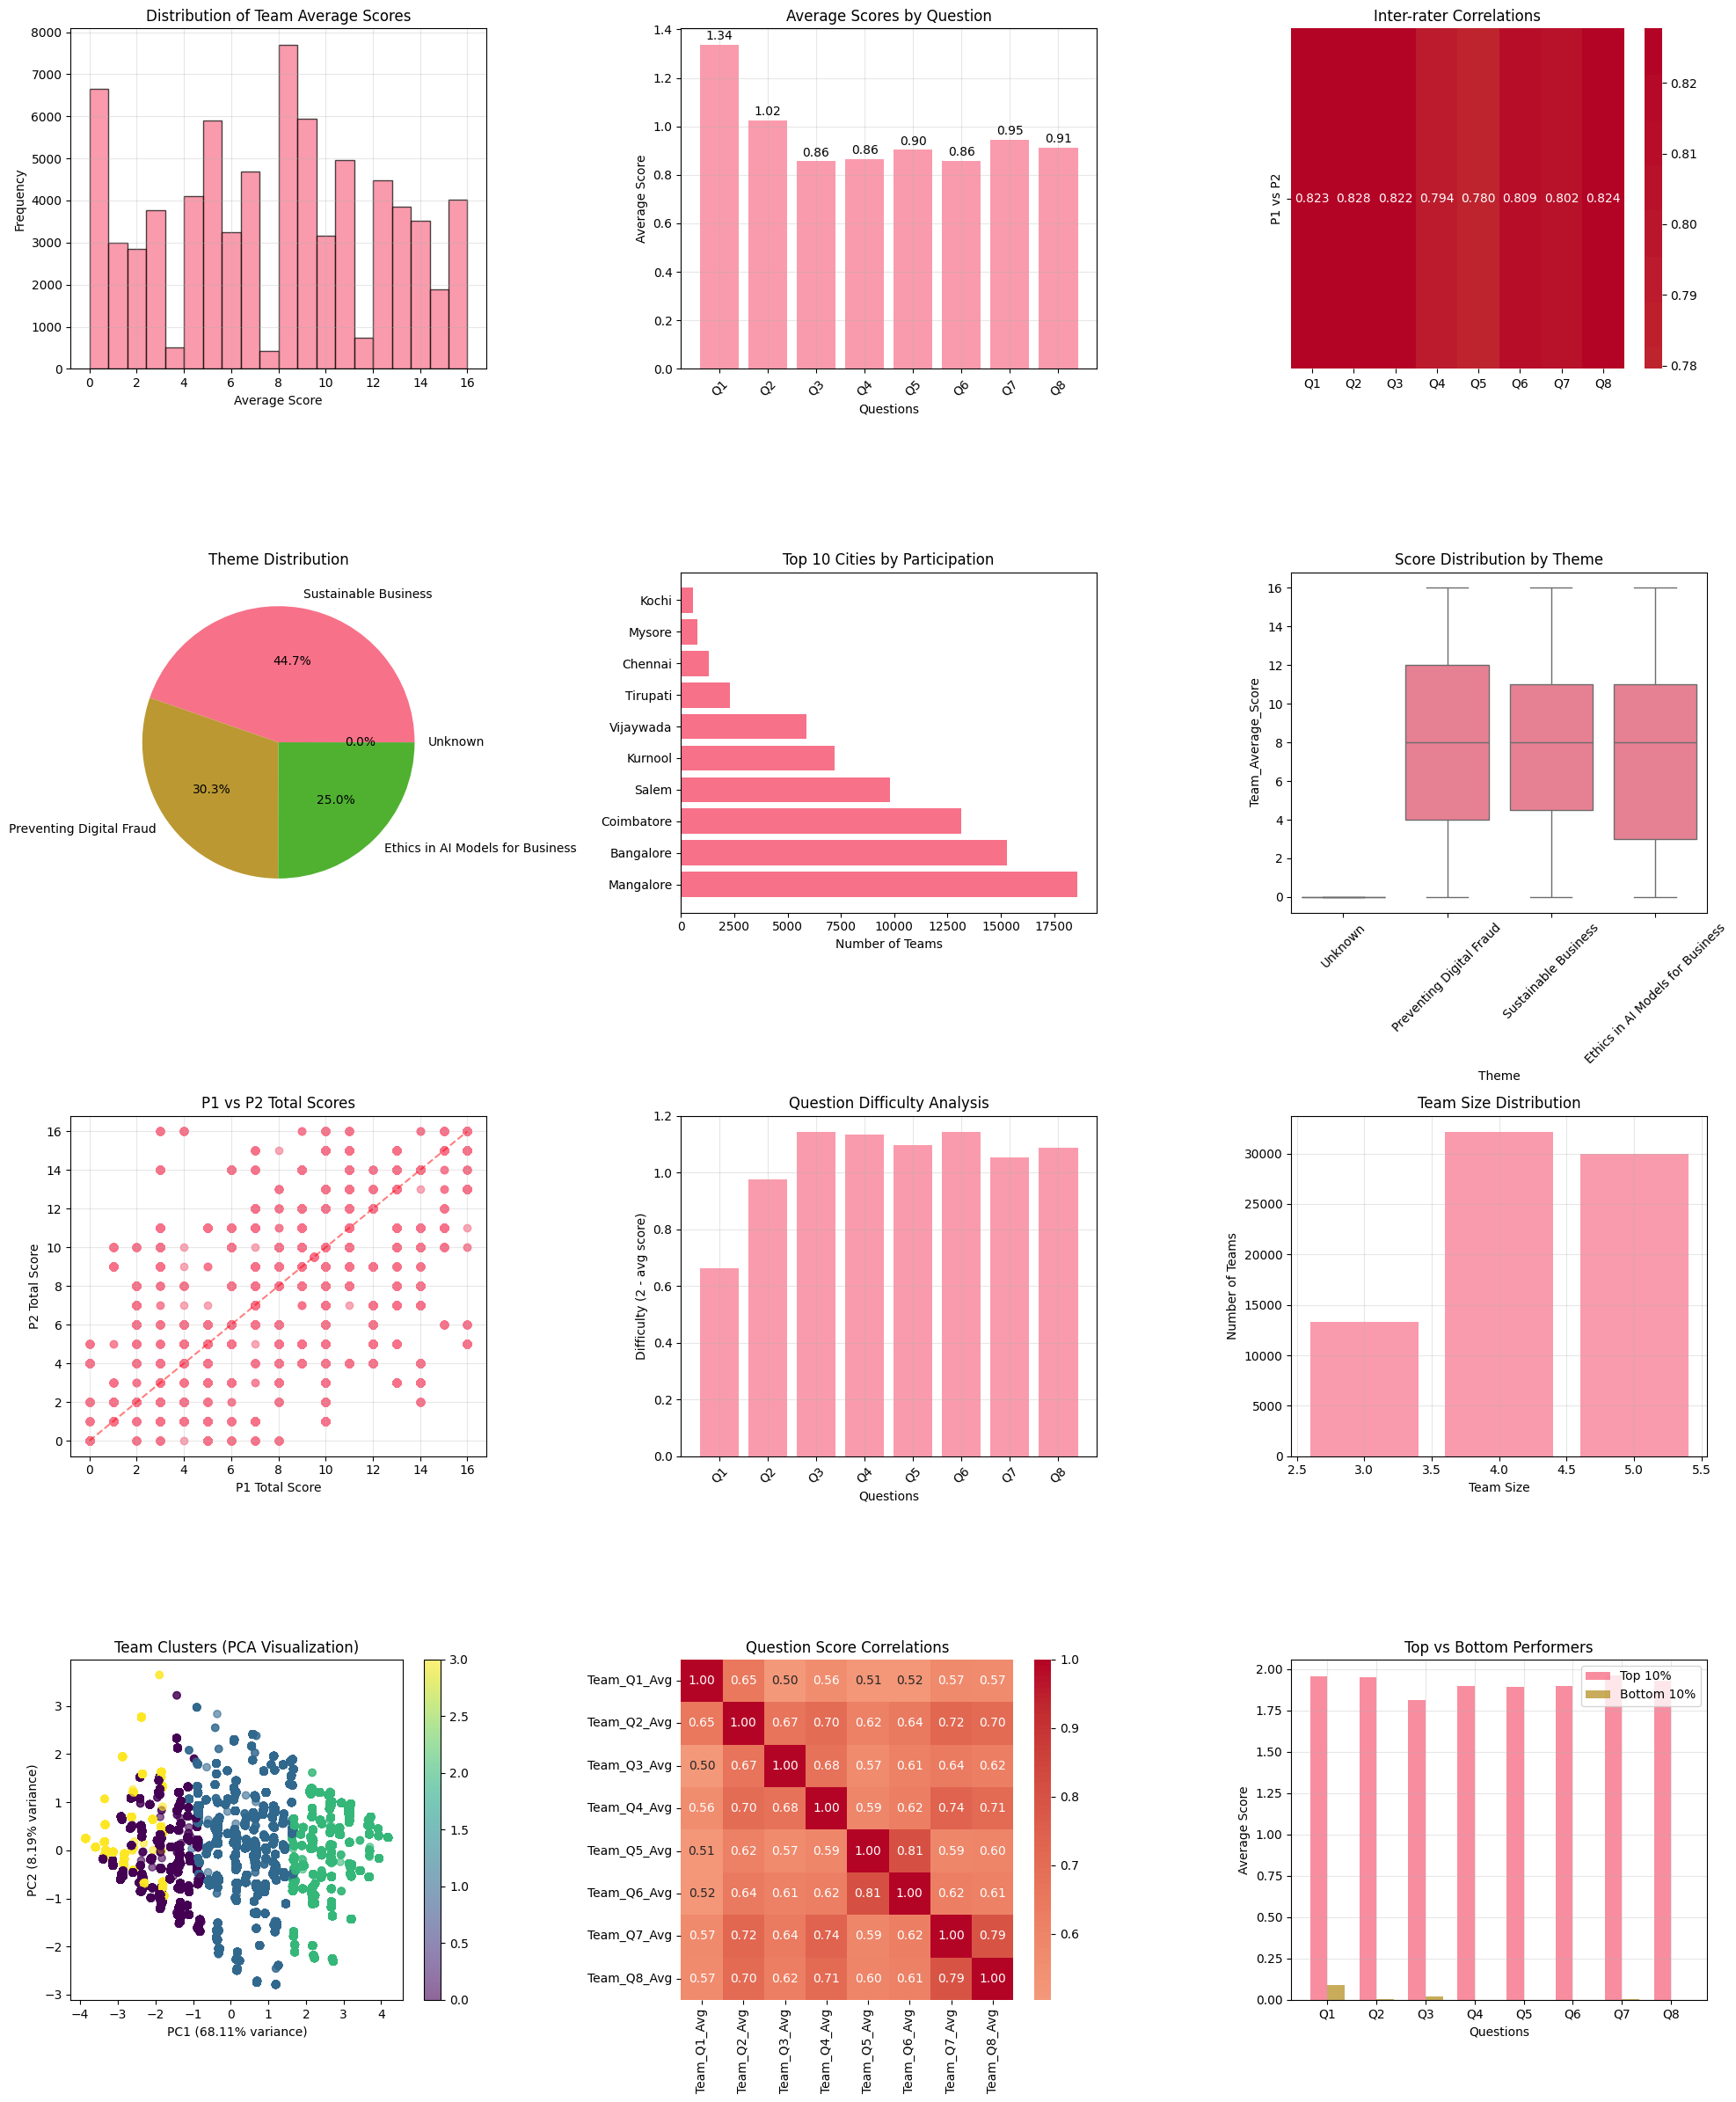

Comprehensive visualization saved as 'hackathon_analysis_comprehensive.png'

KEY INSIGHTS AND RECOMMENDATIONS
📊 PERFORMANCE INSIGHTS:
   • Average team performance: 7.70/2.0 (385.0%)
   • Performance variation: σ = 4.64
   • Strongest area: Q1 (Theme Relevance) - 1.34
   • Weakest area: Q3 (Originality) - 0.86

🤝 EVALUATION CONSISTENCY:
   • Average inter-rater correlation: 0.810
   • Excellent agreement between evaluators

🎯 THEME INSIGHTS:
   • Best performing theme: Sustainable Business (7.83)
   • Most challenging theme: Unknown (0.00)

🌍 PARTICIPATION INSIGHTS:
   • Total cities represented: 19
   • Highest participation: Mangalore (18565 teams)
   • Total colleges represented: 168
   • Most active college: Sri Eshwar College of Engineering (9344 teams)

💡 RECOMMENDATIONS:
   1. Focus on improving teams' performance in: Originality
   2. Use high-performing teams as mentors for improvement areas
   4. Consider theme-specific workshops for challenging themes
   5. Encourage cross-c

True

In [8]:
analyzer.run_complete_analysis()